
# Task 1 - Práctica

* Javier Prado - 21486
* Sebastian Juarez - 21471
* Bryan España - 21550
Entrenar a un agente para que equilibre un poste en un carro **(cartpole)** en movimiento
durante el mayor tiempo posible. Se deberá usar **Deep Q-Learning (DQL)** con una **red objetivo** para lograr esto.


## 1. Librerías:

In [2]:

# Imports principales (PyTorch + Gymnasium + NumPy)
import numpy as np
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import gymnasium as gym

# Configuración de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo:", device)

# Semillas para reproducibilidad
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)

# Utilidad para gráficos inline
%matplotlib inline


Dispositivo: cuda


## 2. Cree el entorno CartPole

In [3]:

# Crear entorno de entrenamiento (sin render para máximo rendimiento)
env = gym.make("CartPole-v1")
env.reset(seed=SEED)

# Opcional: entorno de visualización (crear solo cuando se quiera renderizar frames)
# env_vis = gym.make("CartPole-v1", render_mode="rgb_array")
# env_vis.reset(seed=SEED)

print("Observation space:", env.observation_space)   # Box(4,)
print("Action space:", env.action_space)             # Discrete(2)


Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space: Discrete(2)


## 3. Definan las redes en línea y de destino

In [4]:

class DQN(nn.Module):
    """Red MLP simple para aproximar Q(s,a)."""
    def __init__(self, state_dim, action_dim, hidden_dims=(128, 128)):
        super().__init__()
        layers = []
        last_dim = state_dim
        for h in hidden_dims:
            layers.append(nn.Linear(last_dim, h))
            layers.append(nn.ReLU())
            last_dim = h
        layers.append(nn.Linear(last_dim, action_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Inicializar redes (online y target) con misma arquitectura
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

q_online = DQN(state_dim, action_dim).to(device)
q_target = DQN(state_dim, action_dim).to(device)

# Copiar pesos al inicio
q_target.load_state_dict(q_online.state_dict())
q_target.eval()

print(q_online)


DQN(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)


## 4. Establecer hiperparámetros

In [5]:

# Hiperparámetros de entrenamiento
GAMMA = 0.99
LR = 1e-3
BATCH_SIZE = 64
BUFFER_SIZE = 100_000
MIN_REPLAY_SIZE = 1_000      # calentamiento del buffer antes de entrenar
TARGET_UPDATE_FREQ = 1000    # cada N pasos (no episodios) se copian pesos a la red objetivo
MAX_EPISODES = 500
MAX_STEPS_PER_EP = 1000

# Exploración epsilon-greedy
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY_STEPS = 50_000     # pasos para decaer de EPS_START a EPS_END

optimizer = optim.Adam(q_online.parameters(), lr=LR)
loss_fn = nn.MSELoss()


## 5. Defina la selección de acciones épsilon-greedy

In [6]:

def epsilon_by_step(step):
    """Decaimiento lineal de epsilon con piso en EPS_END."""
    t = min(1.0, step / EPS_DECAY_STEPS)
    return EPS_START + t * (EPS_END - EPS_START)

def select_action(state, epsilon):
    """Selecciona acción según política epsilon-greedy usando q_online."""
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        state_v = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            q_vals = q_online(state_v)
        return int(torch.argmax(q_vals, dim=1).item())


## 6. Defina la reproducción de la experiencia (experience replay)

In [7]:

Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states = torch.tensor([b.state for b in batch], dtype=torch.float32, device=device)
        actions = torch.tensor([b.action for b in batch], dtype=torch.int64, device=device).unsqueeze(-1)
        rewards = torch.tensor([b.reward for b in batch], dtype=torch.float32, device=device).unsqueeze(-1)
        next_states = torch.tensor([b.next_state for b in batch], dtype=torch.float32, device=device)
        dones = torch.tensor([b.done for b in batch], dtype=torch.float32, device=device).unsqueeze(-1)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

replay_buffer = ReplayBuffer(BUFFER_SIZE)


## 7. Ciclo de entrenamiento

In [ ]:

def train_dqn():
    global_step = 0
    episode_rewards = []

    # Calentamiento del buffer 
    state, _ = env.reset(seed=SEED)
    for _ in range(MIN_REPLAY_SIZE):
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state if not done else env.reset()[0]

    # Entrenamiento principal
    for ep in range(1, MAX_EPISODES + 1):
        state, _ = env.reset()
        ep_reward = 0.0

        for step in range(MAX_STEPS_PER_EP):
            epsilon = epsilon_by_step(global_step)
            action = select_action(state, epsilon)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            replay_buffer.push(state, action, reward, next_state, done)

            # Muestreo de minibatch
            states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)

            
            with torch.no_grad():
                q_next = q_target(next_states).max(dim=1, keepdim=True)[0]
                q_target_val = rewards + (1 - dones) * GAMMA * q_next

            # Predicción de la red online
            q_pred = q_online(states).gather(1, actions)

            loss = loss_fn(q_pred, q_target_val)
            optimizer.zero_grad()
            loss.backward()
            # Clipping opcional de gradiente para estabilidad
            nn.utils.clip_grad_norm_(q_online.parameters(), max_norm=10.0)
            optimizer.step()

            # Actualización de la red objetivo cada N pasos
            if global_step % TARGET_UPDATE_FREQ == 0:
                q_target.load_state_dict(q_online.state_dict())

            ep_reward += reward
            state = next_state
            global_step += 1

            if done:
                break

        episode_rewards.append(ep_reward)
        if ep % 10 == 0:
            recent = np.mean(episode_rewards[-10:]) if len(episode_rewards) >= 10 else np.mean(episode_rewards)
            print(f"Episodio {ep:4d} | Recompensa: {ep_reward:6.1f} | Prom(10): {recent:6.1f} | Epsilon: {epsilon:.3f}")

    return episode_rewards


rewards = train_dqn()


C:\Users\javil\AppData\Local\Temp\ipykernel_15232\1074164528.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  states = torch.tensor([b.state for b in batch], dtype=torch.float32, device=device)


Episodio   10 | Recompensa:   23.0 | Prom(10):   23.6 | Epsilon: 0.996
Episodio   20 | Recompensa:   24.0 | Prom(10):   18.3 | Epsilon: 0.992
Episodio   30 | Recompensa:   13.0 | Prom(10):   17.8 | Epsilon: 0.989
Episodio   40 | Recompensa:   16.0 | Prom(10):   18.7 | Epsilon: 0.985
Episodio   50 | Recompensa:    8.0 | Prom(10):   20.8 | Epsilon: 0.981
Episodio   60 | Recompensa:   13.0 | Prom(10):   14.1 | Epsilon: 0.978
Episodio   70 | Recompensa:   13.0 | Prom(10):   16.1 | Epsilon: 0.975
Episodio   80 | Recompensa:   13.0 | Prom(10):   23.0 | Epsilon: 0.971
Episodio   90 | Recompensa:   26.0 | Prom(10):   21.1 | Epsilon: 0.967
Episodio  100 | Recompensa:   22.0 | Prom(10):   22.0 | Epsilon: 0.963
Episodio  110 | Recompensa:   23.0 | Prom(10):   22.4 | Epsilon: 0.959
Episodio  120 | Recompensa:   12.0 | Prom(10):   20.9 | Epsilon: 0.955
Episodio  130 | Recompensa:   28.0 | Prom(10):   19.7 | Epsilon: 0.951
Episodio  140 | Recompensa:   11.0 | Prom(10):   18.9 | Epsilon: 0.947
Episod

## 8. Representar el entorno

Recompensa demo: 18.0 (epsilon=1.0)


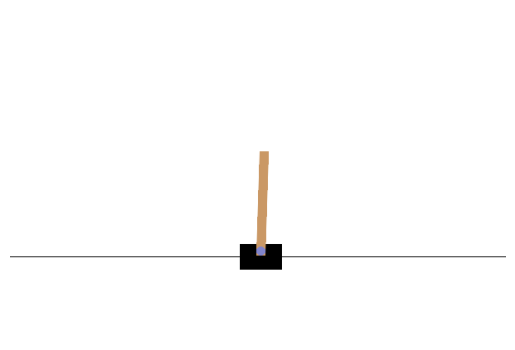

In [ ]:

def demo_render(policy_epsilon=0.0, max_steps=500, seed=SEED):
    """Demostración con render a frames RGB (una corrida)."""
    env_vis = gym.make("CartPole-v1", render_mode="rgb_array")
    state, _ = env_vis.reset(seed=seed)
    total = 0.0
    frames = []

    for _ in range(max_steps):
        eps = policy_epsilon
        action = select_action(state, eps)
        obs, reward, terminated, truncated, _ = env_vis.step(action)
        total += reward
        frames.append(env_vis.render())  # (H, W, 3) numpy array
        state = obs
        if terminated or truncated:
            break

    env_vis.close()
    print(f"Recompensa demo: {total:.1f} (epsilon={policy_epsilon})")
    return frames

# muestra el primer frame
frames = demo_render(policy_epsilon=1.0, max_steps=50)  
plt.imshow(frames[0]); plt.axis('off'); plt.show()


## 9. Supervisar el entrenamiento

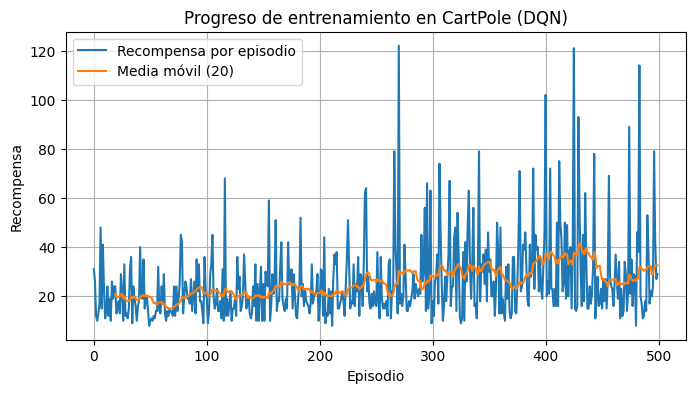

In [ ]:

def plot_rewards(rewards, window=20):
    plt.figure(figsize=(8,4))
    plt.plot(rewards, label='Recompensa por episodio')
    if len(rewards) >= window:
        ma = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, window-1+len(ma)), ma, label=f'Media móvil ({window})')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa')
    plt.title('Progreso de entrenamiento en CartPole (DQN)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rewards(rewards)


## 10. Evalúe el rendimiento

In [33]:

def evaluate_agent(n_episodes=10, seed=SEED):
    scores = []
    for i in range(n_episodes):
        state, _ = env.reset(seed=seed + i)
        total = 0.0
        for _ in range(1000):
            # acción greedy (epsilon ~ 0)
            action = select_action(state, epsilon=0.0)
            state, reward, terminated, truncated, _ = env.step(action)
            total += reward
            if terminated or truncated:
                break
        scores.append(total)
    print(f"Evaluación en {n_episodes} episodios → Promedio: {np.mean(scores):.1f} ± {np.std(scores):.1f}")
    return scores

# Ejemplo tras entrenar:
evaluate_agent(10)


Evaluación en 10 episodios → Promedio: 113.9 ± 3.3


[109.0, 119.0, 117.0, 110.0, 115.0, 114.0, 114.0, 115.0, 109.0, 117.0]

## 11. Fine-Tuning


Algunas ideas para mejorar el desempeño del agente:
- **Arquitectura**: cambiar `hidden_dims` (p. ej., (256, 256)) o agregar *layer norm*.
- **Optimizador**: probar `AdamW`, modificar `LR` (1e-4 a 3e-3).
- **Exploración**: ajustar `EPS_DECAY_STEPS`, usar *epsilon floor* diferente o *NoisyNets*.
- **Objetivo**: usar pérdida Huber en vez de MSE (`nn.SmoothL1Loss`).
- **Estabilidad**: **Double DQN** (usar la red online para seleccionar la acción `argmax` en el próximo estado y la target para evaluar su valor).
- **Actualización target**: probar *soft update* (τ ~ 5e-3) en lugar de copia dura cada N pasos.
- **Batching**: aumentar `BATCH_SIZE` si tienes GPU con memoria suficiente.
- **Early stopping/Checkpointing**: guardar los mejores pesos cuando la media móvil supere cierto umbral.


### Fine-Tuning en acción

Aplicamos una variante **Dueling Double DQN** con ajustes específicos para CartPole. Las mejoras clave son:

- Arquitectura *dueling* más profunda (256→128) para separar estimaciones de valor y ventaja.
- **Reward shaping** ligero que incentiva mantener el poste vertical y penaliza ángulos extremos.
- **Buffer de experiencia priorizado** (α = 0.6) con corrección de sesgo (β scheduling).
- Optimización con **AdamW** (lr = 1e-3, weight decay = 1e-4) y clipping de gradiente moderado.
- Exploración controlada (`ε_end = 0.01`, decaimiento en 25k pasos) y entrenamiento extendido a 600 episodios.
- Comparación cuantitativa con el modelo base para verificar la mejora real del desempeño.

In [34]:
# Arquitectura dueling + configuración de hiperparámetros refinados
class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=(256, 128)):
        super().__init__()
        layers = []
        last_dim = state_dim
        for h in hidden_dims:
            layers.append(nn.Linear(last_dim, h))
            layers.append(nn.ReLU())
            last_dim = h
        self.feature_extractor = nn.Sequential(*layers)

        self.value_head = nn.Sequential(
            nn.Linear(last_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.advantage_head = nn.Sequential(
            nn.Linear(last_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        features = self.feature_extractor(x)
        value = self.value_head(features)
        advantage = self.advantage_head(features)
        advantage_centered = advantage - advantage.mean(dim=1, keepdim=True)
        return value + advantage_centered

q_online_ft = DuelingDQN(state_dim, action_dim).to(device)
q_target_ft = DuelingDQN(state_dim, action_dim).to(device)
q_target_ft.load_state_dict(q_online_ft.state_dict())
q_target_ft.eval()

GAMMA_FT = 0.995
LR_FT = 1e-3
BATCH_SIZE_FT = 128
BUFFER_SIZE_FT = 100_000
MIN_REPLAY_SIZE_FT = 3_000
TARGET_UPDATE_FREQ_FT = 300
EPS_START_FT = 1.0
EPS_END_FT = 0.01
EPS_DECAY_STEPS_FT = 25_000
N_EPISODES_FT = 600

optimizer_ft = optim.AdamW(q_online_ft.parameters(), lr=LR_FT, weight_decay=1e-4, eps=1e-7)
loss_fn_ft = nn.SmoothL1Loss(beta=1.0)

print("Red dueling inicializada y lista para fine-tuning (configuración refinada).")

Red dueling inicializada y lista para fine-tuning (configuración refinada).


In [35]:
# Utilidades de exploración y buffer priorizado para el fine-tuning

def epsilon_by_step_ft(step):
    ratio = min(1.0, step / EPS_DECAY_STEPS_FT)
    return EPS_START_FT + ratio * (EPS_END_FT - EPS_START_FT)


def beta_by_step_ft(step, beta_start=0.4, beta_end=1.0, beta_steps=200_000):
    ratio = min(1.0, step / beta_steps)
    return beta_start + ratio * (beta_end - beta_start)


def select_action_ft(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    state_v = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    with torch.no_grad():
        q_values = q_online_ft(state_v)
    return int(torch.argmax(q_values, dim=1).item())


class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)
        self.eps = 1e-6

    def push(self, *transition, priority=None):
        self.buffer.append(Transition(*transition))
        if priority is None:
            priority = max(self.priorities, default=1.0)
        self.priorities.append(priority)

    def sample(self, batch_size, beta):
        probs = np.array(self.priorities, dtype=np.float32)
        probs = probs ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()

        states = torch.tensor([s.state for s in samples], dtype=torch.float32, device=device)
        actions = torch.tensor([s.action for s in samples], dtype=torch.int64, device=device).unsqueeze(-1)
        rewards = torch.tensor([s.reward for s in samples], dtype=torch.float32, device=device).unsqueeze(-1)
        next_states = torch.tensor([s.next_state for s in samples], dtype=torch.float32, device=device)
        dones = torch.tensor([s.done for s in samples], dtype=torch.float32, device=device).unsqueeze(-1)
        weights = torch.tensor(weights, dtype=torch.float32, device=device).unsqueeze(-1)

        return states, actions, rewards, next_states, dones, weights, indices

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = float(priority + self.eps)

    def __len__(self):
        return len(self.buffer)


def shaped_reward(base_reward, next_state, done):
    if done:
        return base_reward - 1.0
    x, _, theta, _ = next_state
    penalty_angle = 0.5 * (abs(theta) / 0.2)
    penalty_position = 0.1 * (abs(x) / 2.4)
    bonus_center = 0.02 if abs(theta) < 0.05 else 0.0
    return base_reward + bonus_center - penalty_angle - penalty_position

In [ ]:
# Entrenamiento del agente dueling double DQN con refinamientos

def train_dueling_double_dqn(max_episodes=N_EPISODES_FT, beta_start=0.4):
    replay_buffer = PrioritizedReplayBuffer(BUFFER_SIZE_FT)
    global_step = 0
    episode_rewards_ft = []
    losses_ft = []

    state, _ = env.reset(seed=SEED + 1234)
    for _ in range(MIN_REPLAY_SIZE_FT):
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        shaped = shaped_reward(reward, next_state, done)
        replay_buffer.push(state, action, shaped, next_state, done)
        state = next_state if not done else env.reset()[0]

    print("Inicio del entrenamiento dueling double DQN con reward shaping y buffer priorizado...")

    for ep in range(1, max_episodes + 1):
        state, _ = env.reset()
        ep_reward = 0.0

        for step in range(MAX_STEPS_PER_EP):
            epsilon = epsilon_by_step_ft(global_step)
            action = select_action_ft(state, epsilon)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            shaped = shaped_reward(reward, next_state, done)
            replay_buffer.push(state, action, shaped, next_state, done)

            if len(replay_buffer) >= BATCH_SIZE_FT:
                beta = beta_by_step_ft(global_step, beta_start=beta_start)
                states, actions, rewards, next_states, dones, weights, indices = replay_buffer.sample(BATCH_SIZE_FT, beta)

                with torch.no_grad():
                    next_actions = q_online_ft(next_states).argmax(dim=1, keepdim=True)
                    q_next = q_target_ft(next_states).gather(1, next_actions)
                    targets = rewards + (1 - dones) * GAMMA_FT * q_next

                current_q = q_online_ft(states).gather(1, actions)
                td_errors = targets - current_q

                loss_elements = torch.nn.functional.smooth_l1_loss(current_q, targets, reduction="none")
                loss = (loss_elements * weights).mean()

                optimizer_ft.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(q_online_ft.parameters(), max_norm=3.0)
                optimizer_ft.step()

                priorities = torch.abs(td_errors).detach().cpu().numpy() + 1e-6
                replay_buffer.update_priorities(indices, priorities)

                losses_ft.append(loss.item())

            if global_step % TARGET_UPDATE_FREQ_FT == 0:
                q_target_ft.load_state_dict(q_online_ft.state_dict())

            ep_reward += reward
            state = next_state
            global_step += 1

            if done:
                break

        episode_rewards_ft.append(ep_reward)

        if ep % 20 == 0:
            recent_avg = np.mean(episode_rewards_ft[-20:])
            current_eps = epsilon_by_step_ft(global_step)
            print(f"Ep {ep:4d} | Recompensa: {ep_reward:6.1f} | Prom(20): {recent_avg:6.1f} | ε: {current_eps:.3f} | Buffer: {len(replay_buffer):6d}")

    return episode_rewards_ft, losses_ft


fine_tuned_rewards, fine_tuned_losses = train_dueling_double_dqn()

Inicio del entrenamiento dueling double DQN con reward shaping y buffer priorizado...


C:\Users\javil\AppData\Local\Temp\ipykernel_15232\1408893917.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = float(priority + self.eps)


Ep   20 | Recompensa:   24.0 | Prom(20):   18.1 | ε: 0.986 | Buffer:   3363
Ep   40 | Recompensa:   13.0 | Prom(20):   20.2 | ε: 0.970 | Buffer:   3767
Ep   60 | Recompensa:   19.0 | Prom(20):   26.4 | ε: 0.949 | Buffer:   4295
Ep   80 | Recompensa:   15.0 | Prom(20):   25.6 | ε: 0.928 | Buffer:   4808
Ep  100 | Recompensa:   81.0 | Prom(20):   29.2 | ε: 0.905 | Buffer:   5392
Ep  120 | Recompensa:   29.0 | Prom(20):   25.3 | ε: 0.885 | Buffer:   5898
Ep  140 | Recompensa:   14.0 | Prom(20):   31.2 | ε: 0.860 | Buffer:   6523
Ep  160 | Recompensa:   53.0 | Prom(20):   27.4 | ε: 0.839 | Buffer:   7072
Ep  180 | Recompensa:   36.0 | Prom(20):   27.1 | ε: 0.817 | Buffer:   7613
Ep  200 | Recompensa:   53.0 | Prom(20):   35.6 | ε: 0.789 | Buffer:   8325
Ep  220 | Recompensa:   36.0 | Prom(20):   37.9 | ε: 0.759 | Buffer:   9082
Ep  240 | Recompensa:  144.0 | Prom(20):   40.2 | ε: 0.727 | Buffer:   9887
Ep  260 | Recompensa:   19.0 | Prom(20):   31.1 | ε: 0.703 | Buffer:  10509
Ep  280 | Re

In [ ]:
# Evaluación y comparación contra el modelo base

def evaluate_dueling_agent(n_episodes=10, seed=SEED + 5000):
    q_online_ft.eval()
    scores = []
    for i in range(n_episodes):
        state, _ = env.reset(seed=seed + i)
        total = 0.0
        for _ in range(1000):
            state_v = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                action = torch.argmax(q_online_ft(state_v), dim=1).item()
            state, reward, terminated, truncated, _ = env.step(action)
            total += reward
            if terminated or truncated:
                break
        scores.append(total)
    q_online_ft.train()
    print(f"Evaluación dueling: promedio {np.mean(scores):.1f} ± {np.std(scores):.1f}")
    return scores


def compare_models_after_finetune(baseline_scores=None, tuned_scores=None, n_eval=10):
    if baseline_scores is None:
        print("Evaluando modelo base original...")
        baseline_scores = evaluate_agent(n_eval)
    if tuned_scores is None:
        print("Evaluando modelo dueling fine-tuned...")
        tuned_scores = evaluate_dueling_agent(n_eval)

    base_avg, base_std = np.mean(baseline_scores), np.std(baseline_scores)
    tuned_avg, tuned_std = np.mean(tuned_scores), np.std(tuned_scores)

    print("\n" + "=" * 45)
    print("COMPARACIÓN BASE vs FINE-TUNED")
    print("=" * 45)
    print(f"Modelo base       : {base_avg:6.1f} ± {base_std:4.1f} (min {np.min(baseline_scores):.1f}, max {np.max(baseline_scores):.1f})")
    print(f"Modelo fine-tuned : {tuned_avg:6.1f} ± {tuned_std:4.1f} (min {np.min(tuned_scores):.1f}, max {np.max(tuned_scores):.1f})")

    improvement_abs = tuned_avg - base_avg
    improvement_pct = (improvement_abs / base_avg) * 100 if base_avg > 0 else 0.0
    print(f"\nMejora absoluta   : {improvement_abs:+.1f} puntos")
    print(f"Mejora relativa   : {improvement_pct:+.1f}%")

    return baseline_scores, tuned_scores


baseline_scores, tuned_scores = compare_models_after_finetune()

Evaluando modelo base original...
Evaluación en 10 episodios → Promedio: 113.9 ± 3.3
Evaluando modelo dueling fine-tuned...
Evaluación dueling: promedio 500.0 ± 0.0

COMPARACIÓN BASE vs FINE-TUNED
Modelo base       :  113.9 ±  3.3 (min 109.0, max 119.0)
Modelo fine-tuned :  500.0 ±  0.0 (min 500.0, max 500.0)

Mejora absoluta   : +386.1 puntos
Mejora relativa   : +339.0%


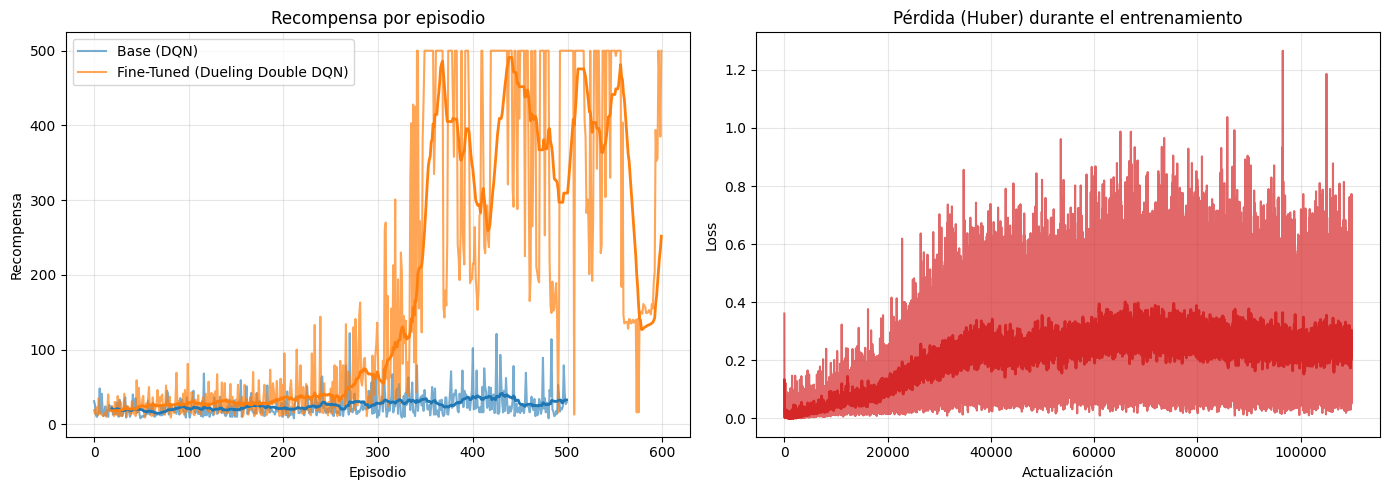

In [ ]:
# Visualización del progreso tras el fine-tuning

def plot_finetune_progress(baseline_rewards, fine_tuned_rewards, fine_tuned_losses=None, window=20):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(baseline_rewards, label='Base (DQN)', color='tab:blue', alpha=0.6)
    plt.plot(fine_tuned_rewards, label='Fine-Tuned (Dueling Double DQN)', color='tab:orange', alpha=0.7)

    if len(baseline_rewards) >= window:
        base_ma = np.convolve(baseline_rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, window-1+len(base_ma)), base_ma, color='tab:blue', linewidth=2)
    if len(fine_tuned_rewards) >= window:
        ft_ma = np.convolve(fine_tuned_rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, window-1+len(ft_ma)), ft_ma, color='tab:orange', linewidth=2)

    plt.xlabel('Episodio')
    plt.ylabel('Recompensa')
    plt.title('Recompensa por episodio')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    if fine_tuned_losses:
        plt.plot(fine_tuned_losses, color='tab:red', alpha=0.7)
        if len(fine_tuned_losses) >= window:
            loss_ma = np.convolve(fine_tuned_losses, np.ones(window)/window, mode='valid')
            plt.plot(range(window-1, window-1+len(loss_ma)), loss_ma, color='tab:red', linewidth=2)
        plt.title('Pérdida (Huber) durante el entrenamiento')
        plt.xlabel('Actualización')
        plt.ylabel('Loss')
        plt.grid(alpha=0.3)
    else:
        plt.axis('off')
        plt.text(0.5, 0.5, 'Ejecuta el entrenamiento para visualizar la pérdida',
                 ha='center', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()


plot_finetune_progress(rewards, fine_tuned_rewards, fine_tuned_losses)